# Isochrone analysis
Note that the API key has a 20 call/minute and 500 call/day limit

In [1]:
# imports
from shapely import Point
from shapely import intersects, difference
from shapely.geometry import shape, mapping
import matplotlib.pylab as plt
import numpy as np
import fiona
import pyproj
from shapely.ops import transform
import requests
import json
import pyproj

In [2]:
# user inputs 
population_fn = "tl_2020_08_tabblock20/tl_2020_08_tabblock20_26913.shp"
center = Point(499949.3,4400390.4) # utm13N
num_bins = 100 # number of steps between zero and max_dist
request_isochrone = True

In [3]:
# Isochrone request
# Commented out by default
body = {"locations":[[-105.00012985139018,39.7531028840525]],"range":[3600],"attributes":["area"],"interval":360,"range_type":"time", "area_units":"km"}
# Latitude in EPSG:4326
headers = {
    'Accept': 'application/json, application/geo+json, application/gpx+xml, img/png; charset=utf-8',
    'Authorization': '5b3ce3597851110001cf624873ff41f6e4a546c8b32558e1e3c9b986',
    'Content-Type': 'application/json; charset=utf-8'
}
if request_isochrone:
    call = requests.post('https://api.openrouteservice.org/v2/isochrones/driving-car', json=body, headers=headers)

print(call.status_code, call.reason)
print(call.text)

200 OK
{"type":"FeatureCollection","bbox":[-105.765089,39.014281,-104.048925,40.571393],"features":[{"type":"Feature","properties":{"group_index":0,"value":360.0,"center":[-104.9997372005485,39.75280276039596],"area":21.826865350000002},"geometry":{"coordinates":[[[-105.027044,39.762012],[-105.027045,39.761593],[-105.027045,39.761551],[-105.026391,39.754837],[-105.026984,39.751214],[-105.026984,39.751212],[-105.027026,39.74321],[-105.028034,39.742214],[-105.028231,39.741441],[-105.028249,39.74136],[-105.028261,39.740592],[-105.028035,39.738614],[-105.026869,39.738614],[-105.025627,39.738659],[-105.020916,39.738236],[-105.017679,39.732204],[-105.017645,39.731615],[-105.017564,39.730786],[-105.017146,39.729751],[-105.013738,39.730911],[-105.005884,39.733657],[-105.00464,39.732471],[-105.00422,39.731904],[-105.002966,39.730844],[-105.000421,39.728716],[-104.992243,39.72811],[-104.990406,39.728126],[-104.990219,39.728207],[-104.983623,39.732504],[-104.981939,39.73336],[-104.978731,39.73544

In [4]:
features_json = json.loads(call.text)['features']
len(features_json)

10

In [5]:
# TODO: Build shells and circles out of isochrones
# Transform..."circles"?
circles_4326 = [shape(f['geometry']) for f in features_json]

project = pyproj.Transformer.from_proj(
    pyproj.Proj('epsg:4326'), # source coordinate system
    pyproj.Proj('epsg:32613'), always_xy=True) # destination coordinate system
circles = [transform(project.transform, c) for c in circles_4326 ]


shells = [circles[0]] # Init with inner isochrone

for i in range(len(circles) - 1):
    isochrone_shell = difference(shape(circles[i+1]),shape(circles[i]))
    shells.append(isochrone_shell)

In [6]:
print(f"lengths: {len(shells)} | {len(circles)}")

lengths: 10 | 10


In [7]:
# print(circles[0])

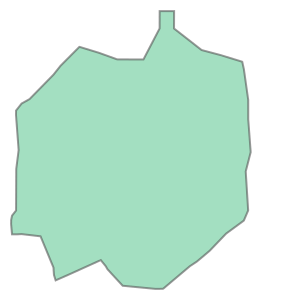

In [8]:
circles[0]

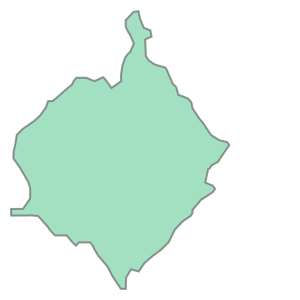

In [9]:
circles[1]

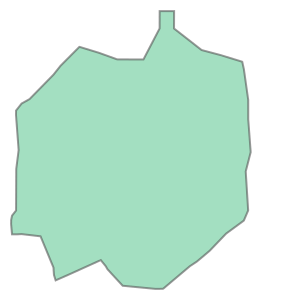

In [10]:
shells[0]

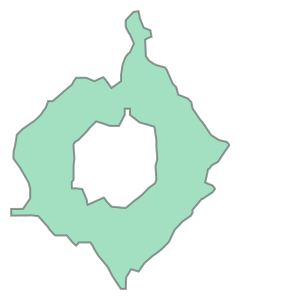

In [11]:
shells[1]

In [12]:
# make radii, open population shapefile
with fiona.open(population_fn) as col:
    info = [(shape(feat['geometry']), feat['properties']['POP20']) for feat in col]


In [13]:
population = [np.nan]
cumulative_population = [0]
avg_population_density = [np.nan]
shell_population_density =[np.nan]
total_area = [0]
shell_area = [0]
# circles = [None] + circles
# shells = [None] + shells

for i in range(len(shells)):
# for i, r in enumerate(rs[1:]):

    # buffer point
    # buffered = center.buffer(r)
    buffered = circles[i]
    shell = shells[i]
    
    # # construct the shell between the two radii
    # if i>0:
    #     shell = buffered.difference(circles[-1])
    # else:
    #     shell = buffered
    
    # # store geometry
    # circles.append(buffered)
    # shells.append(shell)
    
    # store areas
    total_area.append(buffered.area)
    shell_area.append(shell.area)
    
    # determine population in this shell
    pop = 0
    for shp, shp_pop in info:
        if intersects(shell, shp):      
            fraction = shell.intersection(shp).area/shp.area     
            pop += fraction*shp_pop
    
    # store populations
    population.append(pop)
    cumulative_population.append(cumulative_population[-1]+pop)
    
    # calculate population density
    avg_population_density.append(cumulative_population[-1]/total_area[-1])
    shell_population_density.append(pop/shell.area)
    
    print(f'SHELL {i}, cumulative pop: {cumulative_population[-1]}')

SHELL 0, cumulative pop: 87315.97424498406
SHELL 1, cumulative pop: 292731.25646521576
SHELL 2, cumulative pop: 680763.4133767618
SHELL 3, cumulative pop: 1274786.4455624872
SHELL 4, cumulative pop: 2049530.1353346738
SHELL 5, cumulative pop: 2683817.98755387
SHELL 6, cumulative pop: 3005569.659155672
SHELL 7, cumulative pop: 3190043.6480625696
SHELL 8, cumulative pop: 3305774.0427191094
SHELL 9, cumulative pop: 3425914.143243951


In [14]:
len(avg_population_density)

11

## Plots

In [15]:
rs = np.linspace(0, 360.*10, num=11)
rs

array([   0.,  360.,  720., 1080., 1440., 1800., 2160., 2520., 2880.,
       3240., 3600.])

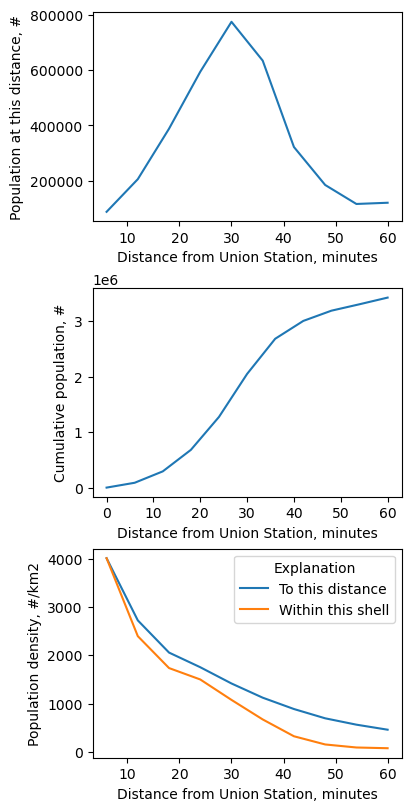

In [16]:
fig, axes = plt.subplots(figsize=(4,8),ncols=1, nrows=3, dpi=100, layout='constrained')

axes[0].plot(rs/60, population)
axes[0].set_xlabel("Distance from Union Station, minutes")
axes[0].set_ylabel("Population at this distance, #")

axes[1].plot(rs/60, cumulative_population)
axes[1].set_xlabel("Distance from Union Station, minutes")
axes[1].set_ylabel("Cumulative population, #")

axes[2].plot(rs/60, np.array(avg_population_density)*1e6, label ='To this distance')
axes[2].plot(rs/60, np.array(shell_population_density)*1e6, label="Within this shell")
axes[2].legend(title='Explanation')
axes[2].set_xlabel("Distance from Union Station, minutes")
axes[2].set_ylabel("Population density, #/km2")
fig.savefig("summary.png", dpi=300)

## Export

In [17]:
with fiona.open(population_fn) as src:
    driver = src.driver
    crs = src.crs
    
schema = {'geometry': 'Polygon',
 'properties': {'pop': 'float',
                'density': 'float',
}}
# shell density
with fiona.open("shells_60min.shp", "w", 
                driver=driver, crs=crs, 
                schema=schema) as dst:

    for i in range(len(shells)):
        feat = {'geometry':mapping(shells[i]),
                'properties':{'pop':population[i+1],
                            'density': shell_population_density[i+1]*1e6}}

        dst.write(feat)
        
# selected tracts, write out density
selection = center.buffer(75000)   
with fiona.open("tract_density_60min.shp", "w", 
                driver=driver, crs=crs, 
                schema=schema) as dst:

    for shp, shp_pop in info:
        if intersects(selection,shp):
            feat = {'geometry':mapping(shp),
                'properties':{'pop':shp_pop,
                            'density': shp_pop/shp.area*1e6}}
            dst.write(feat) 
            

# Density/population calcs


In [18]:
# Explore shell population density
print(len([round(s.area) for s in shells]))
print(len(shell_population_density))
[s*1e6 for s in shell_population_density]
[round(s.area) for s in shells]

10
11


[21782519,
 85773744,
 223701448,
 396456169,
 720339898,
 945350211,
 996927413,
 1205123546,
 1281327728,
 1598308561]

In [19]:
from itertools import accumulate
# What would the incremental population amount to?
reference_density = 2000
# Incremental density
[max(s*1e6, reference_density) - s*1e6  for s in shell_population_density[1:]]
# Area
[round(s.area) for s in shells]
# Incremental population and calculation of moment of inertia
inc_pop = []
minutes = np.linspace(0,60,11)
inc_moment_list = []
inc_moment_hypothetical = []
for i in range(len(shells)):
    s =shells[i]
    spd = shell_population_density[1:][i]
    incr_pop = s.area*(max(spd, reference_density/1e6) - spd)
    inc_pop.append(int(incr_pop))
    inc_moment = population[1:][i]*(minutes[i]**2 + minutes[i+1]**2) * 0.25
    inc_moment_list.append(inc_moment)
    inc_moment_hypothetical.append((population[1:][i] + incr_pop)*(minutes[i]**2 + minutes[i+1]**2) * 0.25)
    # moment of inertia
    
    
print(inc_pop)
print(list(accumulate(inc_pop)))
print(sum(inc_moment_list))
print(sum(inc_moment_hypothetical))
# Scale the moment of inertia
sum(inc_moment_hypothetical) * (sum(population[1:]) / (sum(inc_pop) + sum(population[1:])))

[0, 0, 59370, 198889, 665936, 1256412, 1672103, 2225773, 2446925, 3076477]
[0, 0, 59370, 258259, 924195, 2180607, 3852710, 6078483, 8525408, 11601885]
1603675392.738274
14338461219.631573


3268764548.7180104

In [20]:
from itertools import accumulate
# What would the incremental population amount to?
reference_density = 3000
# Incremental density
[max(s*1e6, reference_density) - s*1e6  for s in shell_population_density[1:]]
# Area
[round(s.area) for s in shells]
# Incremental population and calculation of moment of inertia
inc_pop = []
minutes = np.linspace(0,60,11)
inc_moment_list = []
inc_moment_hypothetical = []
for i in range(len(shells)):
    s =shells[i]
    spd = shell_population_density[1:][i]
    incr_pop = s.area*(max(spd, reference_density/1e6) - spd)
    inc_pop.append(int(incr_pop))
    inc_moment = population[1:][i]*(minutes[i]**2 + minutes[i+1]**2) * 0.25
    inc_moment_list.append(inc_moment)
    inc_moment_hypothetical.append((population[1:][i] + incr_pop)*(minutes[i]**2 + minutes[i+1]**2) * 0.25)
    # moment of inertia
    
    
print(inc_pop)
print(list(accumulate(inc_pop)))
print(sum(inc_moment_list))
print(sum(inc_moment_hypothetical))
# Scale the 
sum(inc_moment_hypothetical) * (sum(population[1:]) / (sum(inc_pop) + sum(population[1:])))

[0, 51905, 283072, 595345, 1386276, 2201762, 2669030, 3430896, 3728252, 4674785]
[0, 51905, 334977, 930322, 2316598, 4518360, 7187390, 10618286, 14346538, 19021323]
1603675392.738274
21505012831.46216


3282111163.1603603

In [21]:
from itertools import accumulate
# What would the incremental population amount to?
reference_scaling = 2
# Incremental density
[max(s*1e6, reference_density) - s*1e6  for s in shell_population_density[1:]]
# Area
[round(s.area) for s in shells]
# Incremental population and calculation of moment of inertia
inc_pop = []
minutes = np.linspace(0,60,11)
inc_moment_list = []
inc_moment_hypothetical = []
for i in range(len(shells)):
    s =shells[i]
    spd = shell_population_density[1:][i]
    incr_pop = population[1:][i]*reference_scaling - population[1:][i]
    # incr_pop = s.area*(max(spd, reference_density/1e6) - spd)
    inc_pop.append(int(incr_pop))
    inc_moment = population[1:][i]*(minutes[i]**2 + minutes[i+1]**2) * 0.25
    inc_moment_list.append(inc_moment)
    inc_moment_hypothetical.append((population[1:][i] + incr_pop)*(minutes[i]**2 + minutes[i+1]**2) * 0.25)
    # moment of inertia
    
    
print(inc_pop)
print(list(accumulate(inc_pop)))
print(sum(inc_moment_list))
print(sum(inc_moment_hypothetical))
# Scale the 
sum(inc_moment_hypothetical) * (sum(population[1:]) / (sum(inc_pop) + sum(population[1:])))

[87315, 205415, 388032, 594023, 774743, 634287, 321751, 184473, 115730, 120140]
[87315, 292730, 680762, 1274785, 2049528, 2683815, 3005566, 3190039, 3305769, 3425909]
1603675392.738274
3207350785.476548


1603676596.5191643